In [1]:
import rasterio
import numpy as np
from rasterio import windows
from itertools import product

# Window loading

In [2]:
def window_overlap(src, overlap, width, height, boundless=True):
    offsets = product(range(0, src.meta['width'], width), range(0, src.meta['height'], height))
    full_window = windows.Window(col_off=0, row_off=0, width=src.meta['width'], height=src.meta['height'])
    for col_off, row_off in offsets:
        window = windows.Window(
            col_off=col_off - overlap,
            row_off=row_off - overlap,
            width=width,
            height=height)
        
        if boundless:
            yield window
        else:
            yield window.intersection(full_window)


In [3]:
def window_retile(src, window, outpath):
    img = src.read([1,2,3], window=w, boundless=False)
    profile = src.profile
    profile.update(
        transform=src.window_transform(window),
        height=window.height,
        width=window.width)
    with rasterio.open(outpath, 'w', **profile) as dst:
        dst.write(img)

In [4]:
width = 5500
height = 5500
overlap = 1

source_data = "../../data/TestDataSet/S2_comp_first.tif"
outdir = "./retiled_images/"

from pathlib import Path
Path(outdir).mkdir(parents=True, exist_ok=True)


In [5]:
%%time
# %load_ext memory_profiler
count=0
with rasterio.open(source_data) as src:
#     print(src.profile)
    for w in window_overlap(src, overlap, width, height):
#         print(w.height)
        outpath = outdir + 'tile_{}.tif'.format(count)
        window_retile(src,w,outpath)
        count+=1

CPU times: user 15.1 s, sys: 609 ms, total: 15.7 s
Wall time: 19.3 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


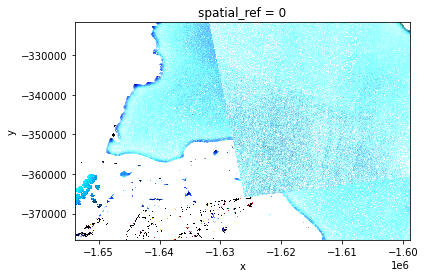

In [6]:
import rioxarray
path_tile = "./retiled_images/tile_1.tif"
tile = rioxarray.open_rasterio(path_tile)
tile.plot.imshow()

In [ ]:
# %%time
# from dask.distributed import Client

# width = 512
# height = 512
# overlap = 4

# client = Client()

# # %load_ext memory_profiler
# with rasterio.open('../../data/TestDataSet/S2_comp_first.tif') as src:
#     for w in window_overlap(src, overlap, width, height):
#         ls_stamp.append(src.read([1,2,3], window=w, boundless=True))
# stamp = np.stack(ls_stamp)